<a href="https://colab.research.google.com/github/mmosoriov/proj5_DL/blob/ML_part2/Part1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Miguel Mateo Osorio Vela, Matthew West

Development environment: Colab

# Part 1, ML: Baseline, PCA, Logistic Regression

- Task:
  - Come up with and implement a baseline for this task
    - Consider what technqiues we've covered in class might be relevant. Or come up with something all on your own.
    - Include a description of your baseline to accompany the implementation and explain why this baseline makes sense for this problem.
  - Compare the performance of your simple baseline with two of the following of your choice: PCA and Logistic Regression. Compare their performance on the Olivetti faces dataset on different evaluation scenarios
  - *If hyperparameters need to be selected, pull out a reasonable held-out set from the training set and performance hyperparameter selection.


- Evaluation scenarios:
  - Use 30% of the images for training and 70% for testing
  - Use 60% of the images for training and 40% for testing
  - Use 90% of the images for training and 10% for testing
  - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
  - Choose an evaluation method: CMC curve or confusion matrix. Run this for each combination of scenario and method.


- Discussion:
  - If you used a held-out set, how did you choose your method of held-out set selection method? If not, why was it not necessary?
    - What effect did your choice have on your final results?
  - Is there a clear difference in performance for different approaches?
  - Is there a clear difference in performance for different train/test data splits?

## Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"*There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


In [1]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np

# Get the dataset

In [73]:
faces = images = fetch_olivetti_faces()

_, img_height, img_width = images.images.shape

print(images.images.shape)

(400, 64, 64)


# Split the dataset

In [74]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 5                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices].reshape(-1, img_height*img_width) # vectorize train images
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices].reshape(-1, img_height*img_width)    # vectorize test images
y_test = faces.target[probe_indices]

print(x_train.shape, x_test.shape)

(200, 4096) (200, 4096)


# Visualize the splits

In [75]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
      else:
        row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
    cv2_imshow(row)

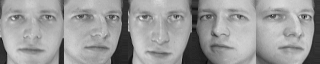

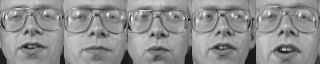

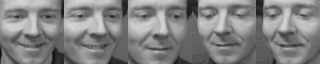

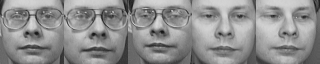

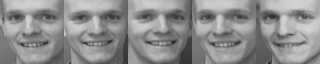

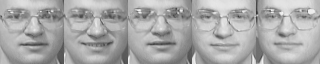

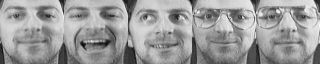

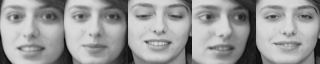

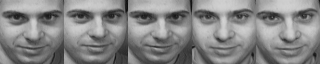

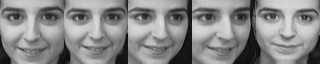

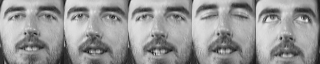

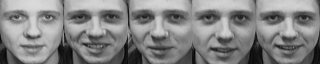

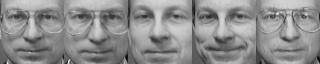

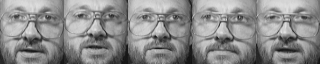

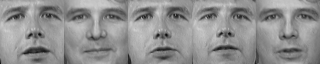

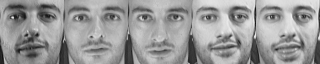

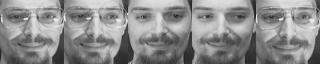

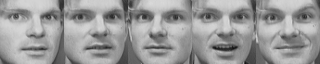

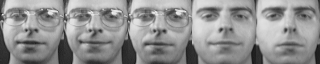

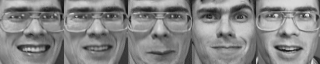

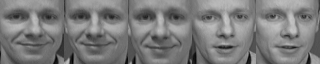

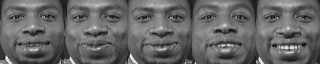

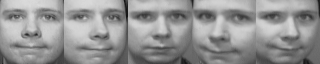

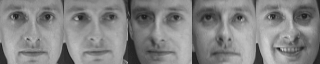

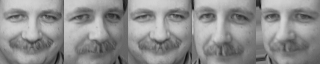

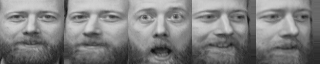

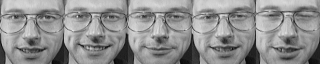

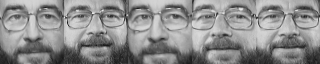

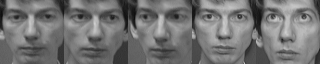

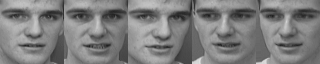

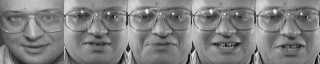

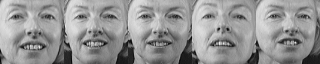

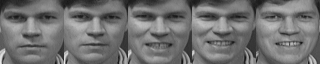

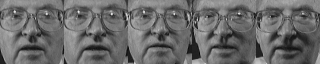

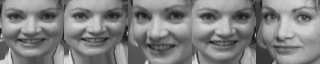

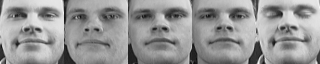

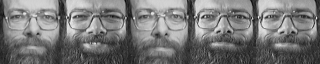

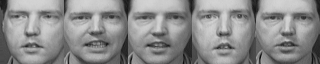

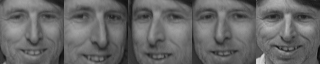

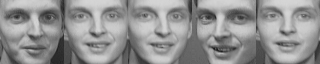

In [5]:
show_images(x_train, N_IDENTITIES, GALLERY_SIZE)

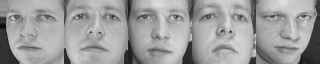

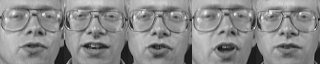

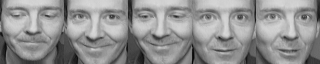

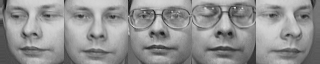

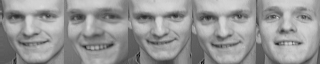

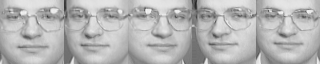

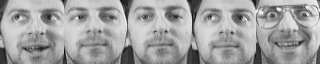

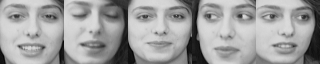

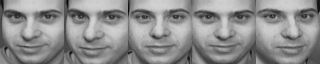

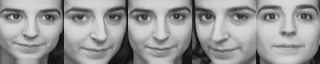

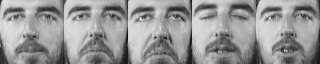

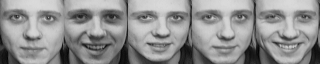

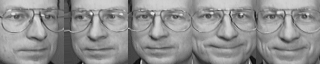

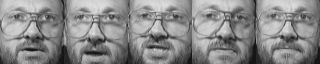

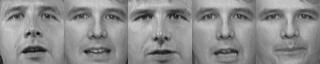

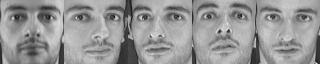

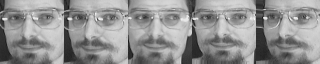

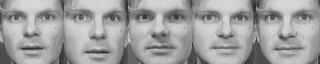

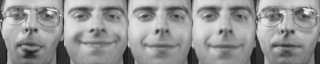

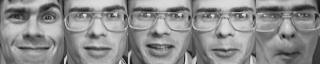

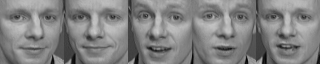

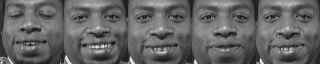

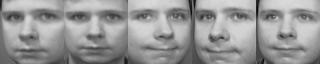

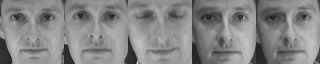

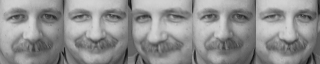

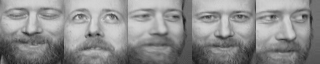

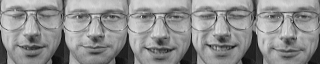

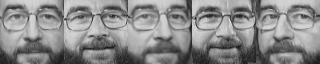

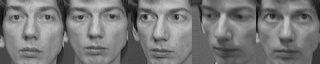

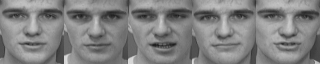

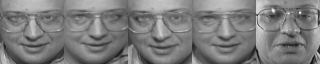

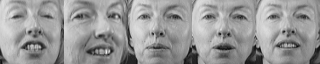

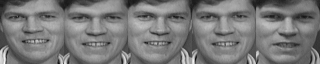

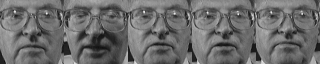

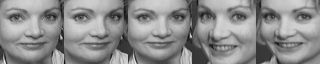

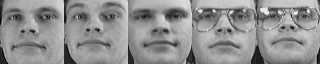

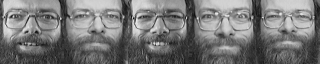

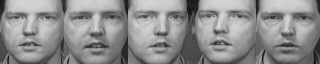

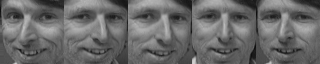

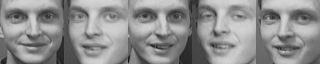

In [6]:
show_images(x_test, N_IDENTITIES, 10 - GALLERY_SIZE)

# Implement your baseline

For our baseline we chose to implement a Naive Bayes Model. We chose this because we wanted to classify the images into the labels of people based on their features. It should also provide us with a decent starting point to compare against the other models. It is reasonable to assume that the Naive Bayes models should perform worse than all the other ones since it assumes the pixels are all independent of each other, something that is unlikely to be true for faces.

The Naive Bayes model works by assuming all features are independent of each other and then determining the probabilities of features given the label. Then the model can determine what label is most likely given the features present in the test example. The features of each image are either a 1 or a 0 for each pixel depending on if the intensity is over the threshold or not.

The threshold and the smoothing rate are both found using a held-out set.

In [76]:
"""
DATA setup
"""
# Baseline
from sklearn.preprocessing import Binarizer # maps continous values -> 0 or 1
from sklearn.naive_bayes import BernoulliNB # Bernoulli(0 or 1) classifier in baseline
from sklearn.metrics import accuracy_score # to calculate how many predictions were correct
# PCA
from sklearn.model_selection import train_test_split # used in PCA to create small held-out set to tune number eigenfaces
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbors classifier
# Logistic regression
from sklearn.linear_model import LogisticRegression


print("Preparing Olivetti Faces dataset....")
X_full = images.data  # By documentation: shape of (400, 4096) => 400 images, 64x64 pixels flattened
y_full = images.target # Shape of (400,) => Labels associated with each image 0-39 // THE ANSWERS


# Reshape to (40 people, 10 images, 4096 pixels) to organize data by person
X_by_person = X_full.reshape(40, 10, 4096) # this forms a 3d block, which allows us to later say X_by_personl[0, :3] to retrieve the first 3 images of person 0
# Reshape to match structure above
y_by_person = y_full.reshape(40, 10)

Preparing Olivetti Faces dataset....


In [8]:
"""
MODEL DEFINITIONS

"""

"""
BASELINE: Naive Bayes(Bernoulli, 0 or 1)
Logic: Feature values for each pixel are black or white depending if the intensity is > or < than 0.5
This is a simple and efficient way to generate an acceptable baseline that ignores noise.
It has the downside that we loose some "texture" data by categorizing everything as black or white.
"""

def run_baseline_naive_bayes(X_train, y_train, X_test, y_test):
  # count images
  n_samples = len(X_train)

  # count people, should be 40
  n_classes = len(np.unique(y_train))

  best_t = 0.5
  best_a = 1

  if n_samples * 0.2 >= n_classes:
    X_tr_sub, X_held_out, y_tr_sub, y_held_out = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

    best_acc = -1
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for t in thresholds:
      # Create binarizer
      to_binary = Binarizer(threshold=t)
      X_train_bin = to_binary.transform(X_tr_sub)

      Naive_Bayes_model = BernoulliNB(alpha=1, binarize=None) # initializes model which assumes pixels are independent
      Naive_Bayes_model.fit(X_train_bin, y_tr_sub)

      # Test on held-out set
      y_pred = Naive_Bayes_model.predict(X_held_out)

      acc = accuracy_score(y_held_out, y_pred)
      # print("Acc: ", acc, " Threshold: ", t)

      if acc > best_acc:
          best_acc = acc
          best_t = t

      best_acc = -1
      alphas = [1e-3, 1e-2, 1e-1, 1.0, 10.0]
      for a in alphas:
        # Create binarizer
        to_binary = Binarizer(threshold=best_t)
        X_train_bin = to_binary.transform(X_tr_sub)

        Naive_Bayes_model = BernoulliNB(alpha=a, binarize=None) # initializes model which assumes pixels are independent
        Naive_Bayes_model.fit(X_train_bin, y_tr_sub)

        # Test on held-out set
        y_pred = Naive_Bayes_model.predict(X_held_out)

        acc = accuracy_score(y_held_out, y_pred)

        if acc > best_acc:
            best_acc = acc
            best_a = a


  # Turn grayscale into 0 or 1
  to_binary = Binarizer(threshold=best_t)
  X_train_bin = to_binary.transform(X_train)
  X_test_bin = to_binary.transform(X_test)

  Naive_Bayes_model = BernoulliNB(alpha=best_a, binarize=None) # initializes model which assumes pixels are independent

  # Training: counts how often each pixel for person X is black/white
  Naive_Bayes_model.fit(X_train_bin, y_train)

  # Test model
  y_pred = Naive_Bayes_model.predict(X_test_bin)

  # print(f"Threshold: {best_t} alpha: {best_a}")
  return y_test, y_pred

"""
PCA: Principal Component Analysis
Problem: images are high dimensional data, in this case (64x64 pixels)= 4096 features. Some of these pixels are redundant(like background).
Logic: Finds the "principal components" which are the directions with maximum variance (these are called Eigenfaces)
  - It uses the classifier of the 1 nearest neighbour
  - It tunes the hyperparameters in a held-out set
"""

def run_pca_eigenfaces(X_train, y_train, X_test, y_test):

    # count images
    n_samples = len(X_train)

    # count people, should be 40
    n_classes = len(np.unique(y_train))

    # Default best number of components
    best_n = min(n_samples, 50)

    """
    We check that: Held-out set size > n_classes
    - This assures we have at least one image of each person for hyperparameters (#components) tuning
    """
    # If 20% of our data is greater than 40(people), then we know we will have an image of each person in held-out set
    if n_samples * 0.2 >= n_classes:
        # Create a 20% held-out set, stratify by labels to make sure each person is included, more info at: https://scikit-learn.org/stable/modules/cross_validation.html#stratification
        X_tr_sub, X_held_out, y_tr_sub, y_held_out = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

        best_acc = -1
        component_options = [20,40,60, 80,100,120, 140]

        for n in component_options:
            if n > len(X_tr_sub): continue

            #create PCA model
            pca = PCA(n_components=n, random_state=42)
            # Fit the model with training set and apply the dimensionality reduction on it.
            X_tr_pca = pca.fit_transform(X_tr_sub)
            # Just apply dimensionality reduction on held-out set.
            X_PCA_held_out = pca.transform(X_held_out)

            # Create Classifier of 1 nearest neighbour, "find the closest structural match"
            knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
            # Train the classiffier on the dimensional reduced data
            knn.fit(X_tr_pca, y_tr_sub)
            # Evaluate accuracy in the held-out set
            acc = knn.score(X_PCA_held_out, y_held_out)

            if acc > best_acc:
                best_acc = acc
                best_n = n
    else:
        # if data is too small, we guess 40 components as we cannot have more components than images
        best_n = min(40, n_samples)

    # Fit on FULL training set with the chosen number of components
    final_pca = PCA(n_components=best_n, random_state=42)
    X_train_pca = final_pca.fit_transform(X_train)
    # Apply dimensionality reduction on test set
    X_test_pca = final_pca.transform(X_test)

    # Train Nearest neighbour classifier on training set
    final_knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    final_knn.fit(X_train_pca, y_train)

    # Predict labels on test set the model hasnt seen before
    y_pred = final_knn.predict(X_test_pca)

    return y_test, y_pred

"""
Logistic Regression

"""

def run_logistic_regression(X_train, y_train, X_test, y_test):
    """
    solver was set to 'saga' because:
    1) faster for large data sets(4096 features) https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression-solvers
    2) It provides a penalty for L1 Regularization which is desired in our case, as we are trying to eliminate useless features(background)

    'C' was set to a smaller value from 1(default) to 0.05 to strengthen regularization

    'max_iter' was tuned to 400 iterations so that the solver will converge for all k values in around 1 min runtime
    """

    logis_reg = LogisticRegression(max_iter=400, solver = 'saga', C= 0.05 ,random_state=42)
    logis_reg.fit(X_train, y_train)
    y_pred = logis_reg.predict(X_test)

    return y_test, y_pred

# Run the experiments


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

"""
400 images in total , 10 images per  person
We choose first k images per person for training, and the rest for testing

k=3 (30% Train), k=6 (60% Train), k=9 (90% Train)
"""
train_sizes = [3, 6, 9]

# Create dict to store results
results = {
    'train_k': [],
    'Baseline': [],
    'PCA': [],
    'Logistic Regression': []
}

print(f"{'Images/Person train':<20} | {'Baseline':<15} | {'PCA':<15} | {'Logistic Reg ':<15}")
print("-" * 70)

for k in train_sizes:
    # Construct the split manually to ensure exactly k images per person
    X_train_list, y_train_list = [], []
    X_test_list, y_test_list = [], []

    for p_id in range(40):
        # Taking first k for train, rest for test
        X_train_list.append(X_by_person[p_id, :k, :])
        y_train_list.append(y_by_person[p_id, :k])
        X_test_list.append(X_by_person[p_id, k:, :])
        y_test_list.append(y_by_person[p_id, k:])

    # Use vstack to concatenate into a matrix and preserving k balance
    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)

    # Run Models
    nb_test, nb_pred = run_baseline_naive_bayes(X_train, y_train, X_test, y_test)
    pca_test, pca_pred = run_pca_eigenfaces(X_train, y_train, X_test, y_test)
    lr_test, lr_pred = run_logistic_regression(X_train, y_train, X_test, y_test)

    acc_nb = accuracy_score(nb_test, nb_pred)
    acc_pca = accuracy_score(pca_test, pca_pred)
    acc_lr = accuracy_score(lr_test, lr_pred)

    # Store Results
    results['train_k'].append(k)
    results['Baseline'].append((nb_test, nb_pred))
    results['PCA'].append((pca_test, pca_pred))
    results['Logistic Regression'].append((lr_test, lr_pred))

    print(f"{k:<20} | {acc_nb:.4f}          | {acc_pca:.4f}          | {acc_lr:.4f}")

Images/Person train  | Baseline        | PCA             | Logistic Reg   
----------------------------------------------------------------------
3                    | 0.5857          | 0.7536          | 0.7607
6                    | 0.6500          | 0.8625          | 0.8938
9                    | 0.7000          | 0.9000          | 0.9250


# Report your results

### Hyperparameter Selection
To find our hyperparameters we used a held-out set. We chose the set using the `train_test_split` function from scikit-learn. We used it to take 20% of the test set and use that as the held-out set.

The final choices of hyperparameters grealy affected our results. For example, the Naive Bayes model's accuracy changed by 80% at most between threshold hyperparamter choices.


### Model Differences
There is a clear performance difference between the Naive Bayes model, the PCA model, and the Logistic Regression model. Naive Bayes was by far the worst of the three. It was consistently over 10% less accurate than the other two models were. The difference between the PCA and Logistic Regression models was consistent, but far closer. Those two saw only around a 5% difference in accuracy at most.
  
There was also a clear difference in training and test data splits as well. The splits where more data was left for training did better. The jump from 30% to 60% made a large difference. The training splits made such a difference, that the Naive Bayes model with 90% training data will beat the other two at 30% training data. The CMC matrices also show that the classifications are more centered on the diagonal line for the models with a higher training data split.

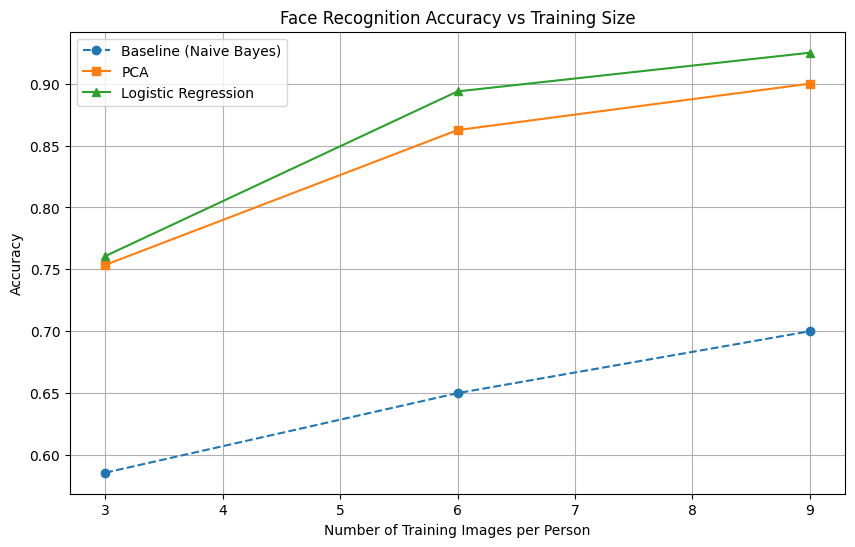

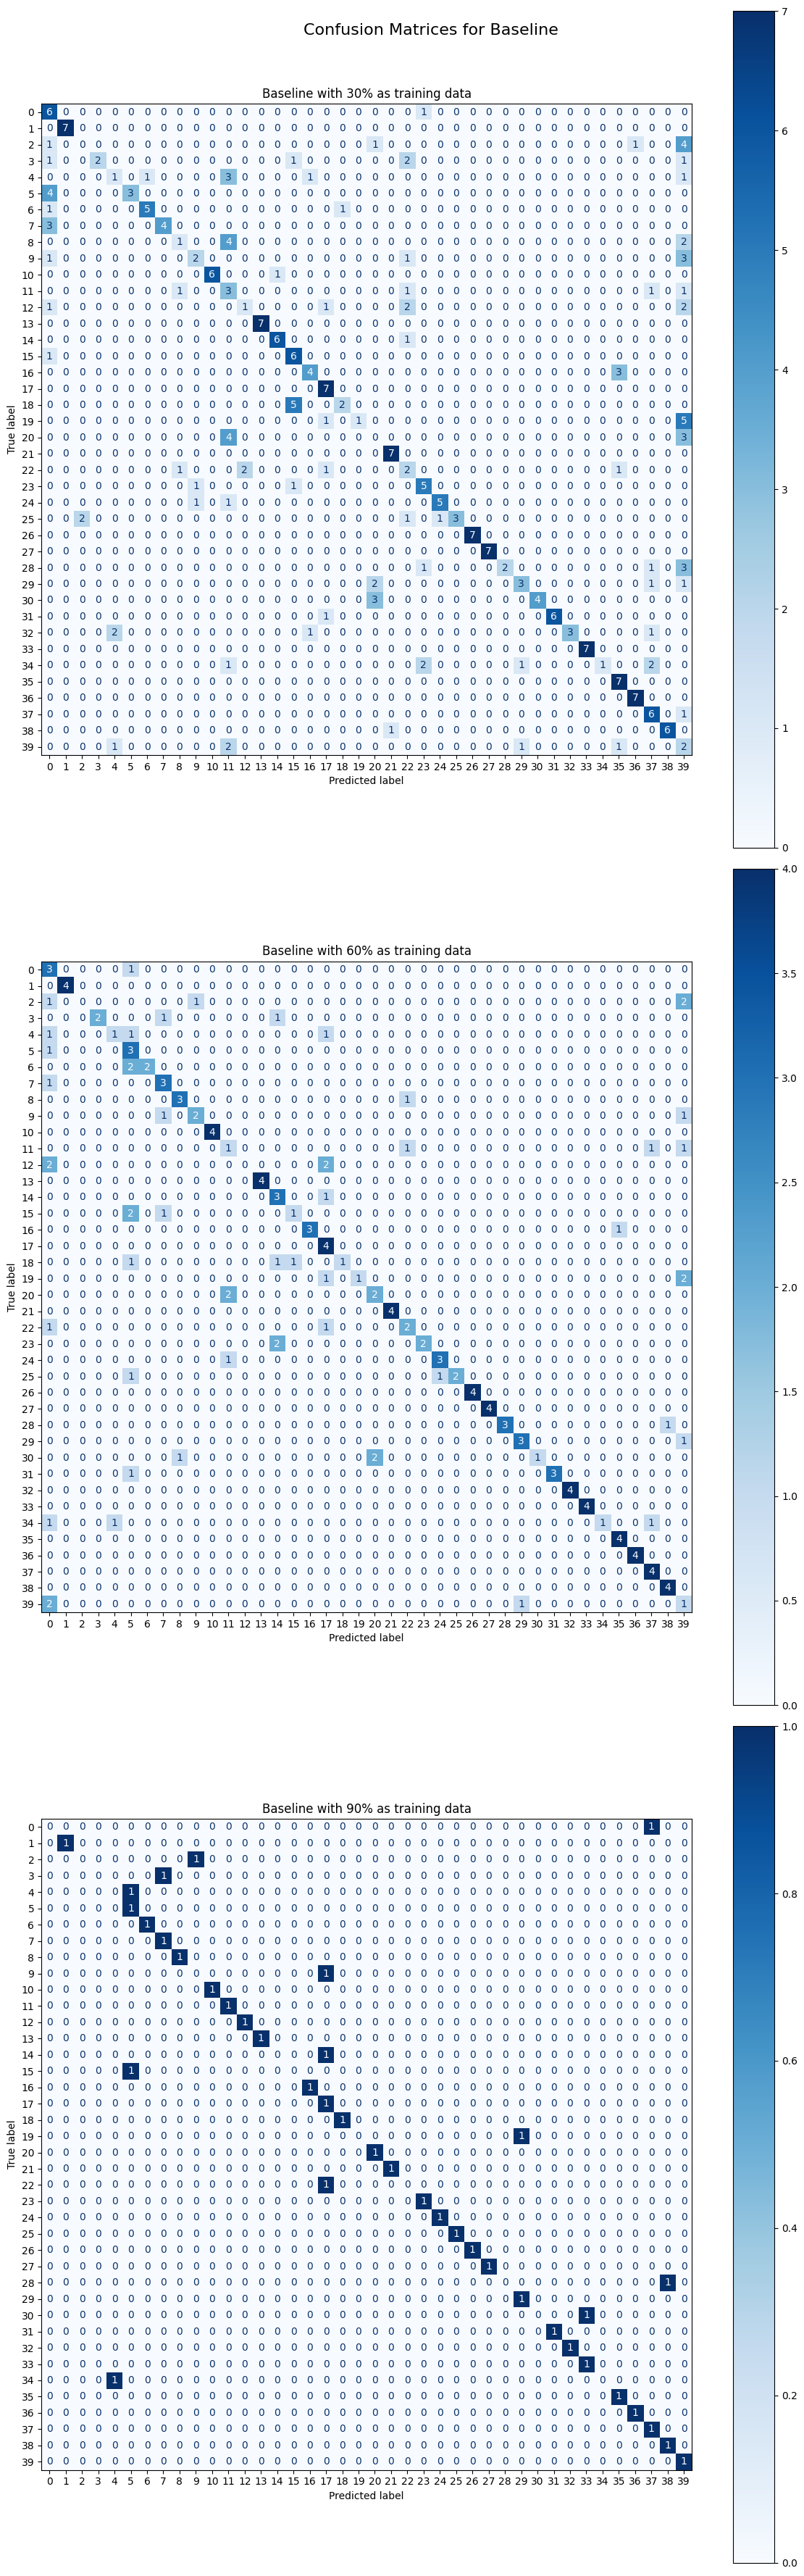

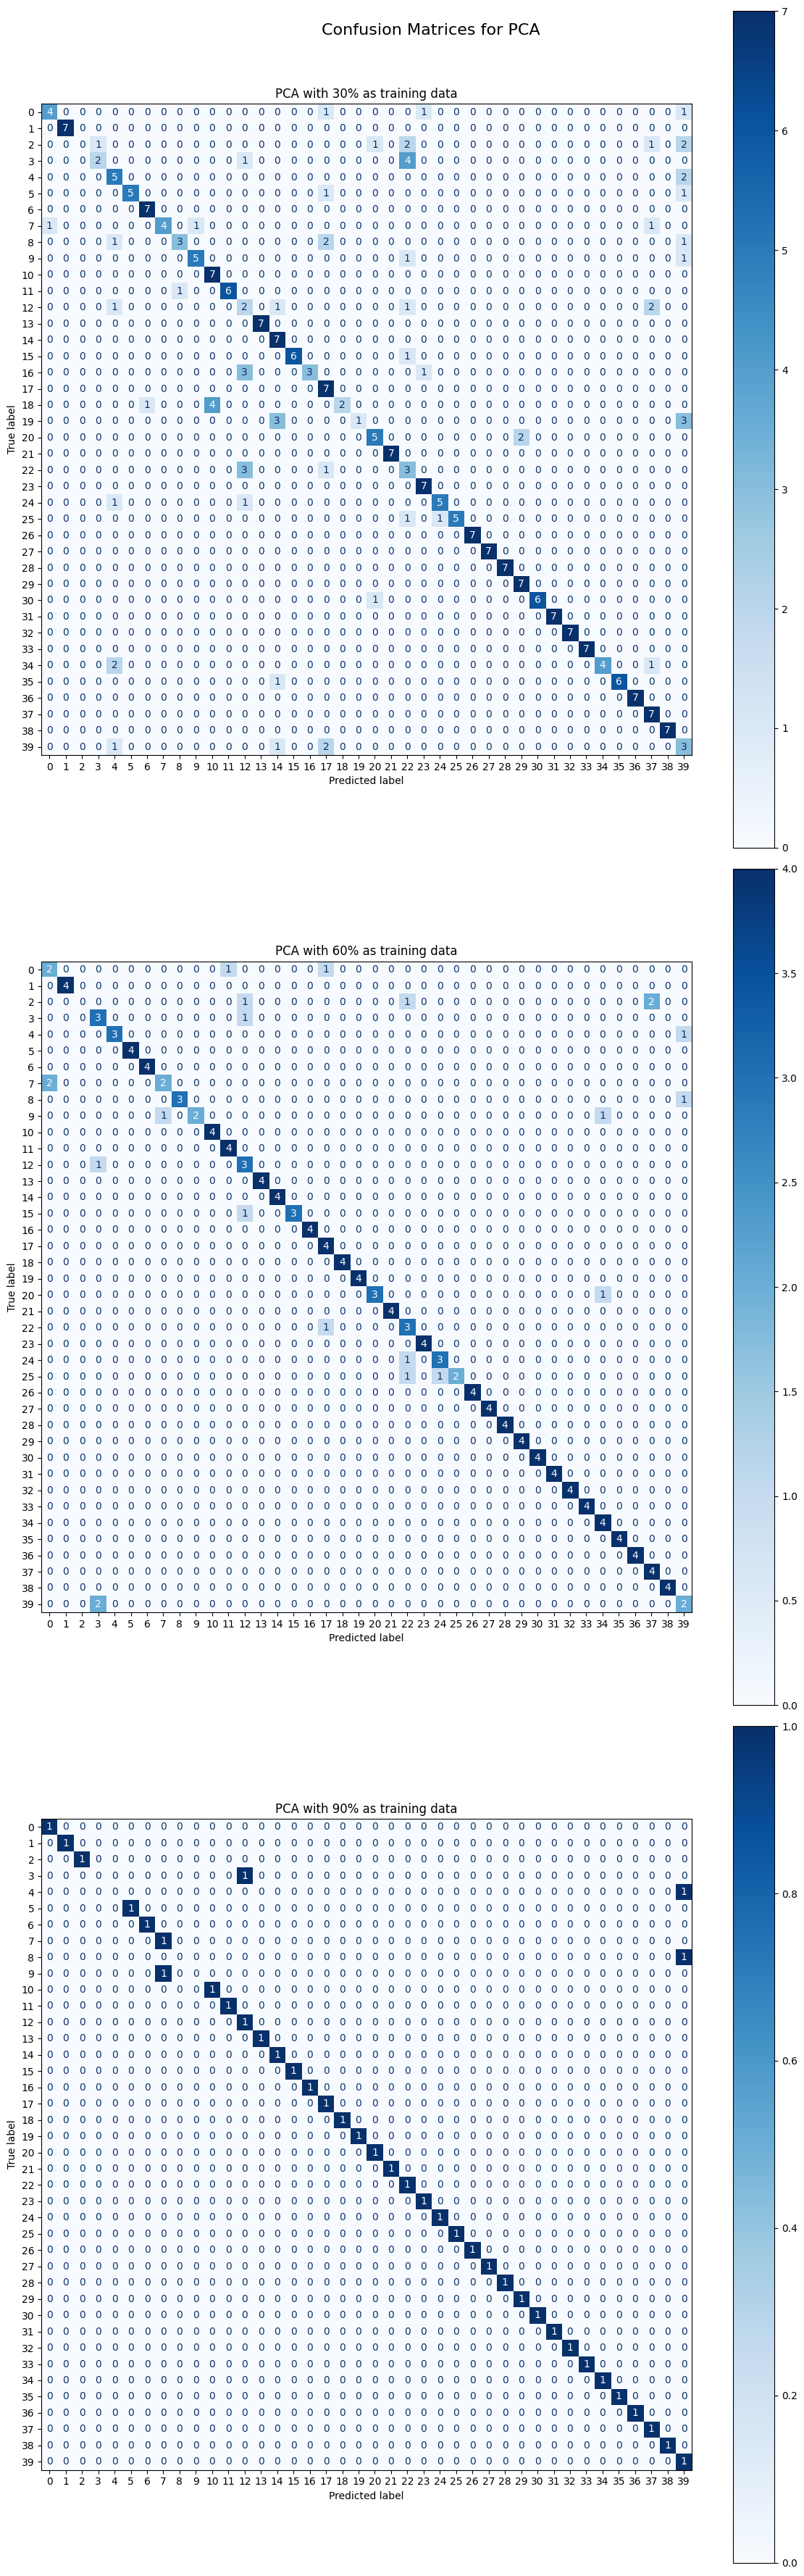

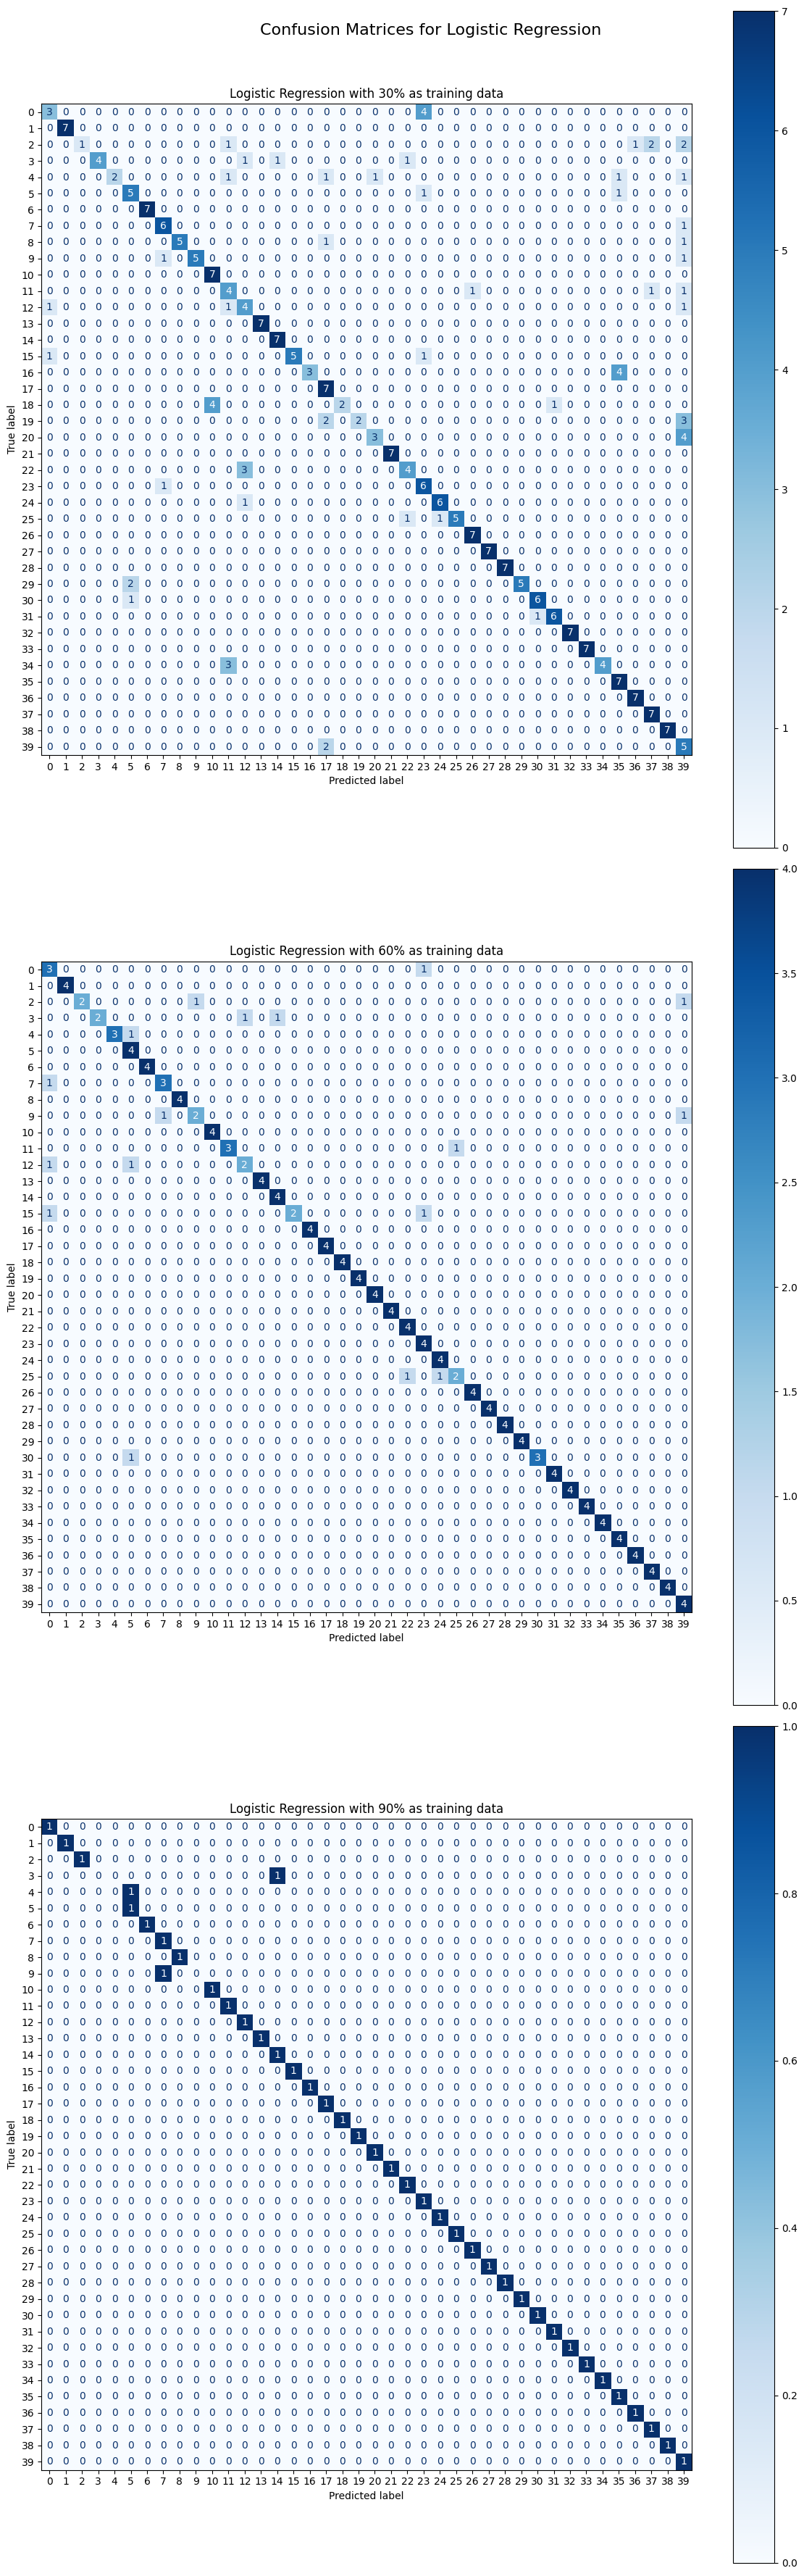

In [10]:
import matplotlib.pyplot as plt # for plotting results

plt.figure(figsize=(10, 6))
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['Baseline']], marker='o', linestyle='--', label='Baseline (Naive Bayes)')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['PCA']], marker='s', label='PCA')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['Logistic Regression']], marker='^', label='Logistic Regression')

plt.title('Face Recognition Accuracy vs Training Size')
plt.xlabel('Number of Training Images per Person')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

labels = ['Baseline', 'PCA', 'Logistic Regression']
for label in labels:

  fig, axes = plt.subplots(len(train_sizes), 1, figsize=(12, 36))
  fig.suptitle(f"Confusion Matrices for {label}", fontsize=16)

  for ax, (test, pred), size in zip(axes, results[label], train_sizes):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test, pred))
    disp.plot(cmap='Blues', ax=ax, colorbar=True)
    ax.set_title(f"{label} with {size*10}% as training data")

  plt.tight_layout()
  plt.show()

# Part 2, DL: CNN and RNN

- **Tasks:**
  1. Compare the performance of a small CNN (LeNet-5) with the results you got from the last project using the Olivetti faces dataset (PCA and Logistic Regression)
  2. Choose, implement (if not available in a library), and run a baseline for the IMDB text classification from lecture
    - Consider what techniques would be appropriate for this task.
    - Also consider the fact that this is a text dataset, so some techniques might not work well or may be cumbersome to engineer.
    - Include a description of your baseline and explain why this baseline makes sense for this problem.
  3. Run a vanilla RNN on the IMDB text classification dataset and compare its performance against your baseline.

_Where it is relevant, make sure you follow deep learning best practices discussed in class. In particular, performing a hyperparameter search and setting up an proper train, dev, and test framework for evaluating hyperparameters and your final selected model._

- Evaluation scenarios:
  1. Facial Recognition
    - Use 20% of the images for training and 80% for testing
    - Use 50% of the images for training and 50% for testing
    - Use 80% of the images for training and 20% for testing
    - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
    - Plot CMC curve and confusion matrix for each combination of scenario

  2. Review Text Classification
    - Use 2,000 examples for training and 2,000 examples for testing (smaller than the example in lecture)
    - Experiment with several RNN configurations
    - Plot the training and validation plots for your RNN and for your baseline if your baseline has a training phase.
    - Plot a confusion matrix of the predictions.

- Discussion:
  1. Facial Recognition
    - Is LeNet-5 better than PCA/LDA/SVM?
    - Is there a clear difference in performance for different train/test data splits?
    - (extra credit) Does data augmentation improve the results?
  
  2. Review Text Classification
    - Is the vanilla RNN better than a simple baseline?
    - How sensitive is the RNN performance to hyperparameter selection?
    - (extra credit) Does data augmentation improve the results? More or less than for the facial recognition task? What properties of the two tasks do you think is leading to the data augmentation effects you are seeing?


# Run the facial recognition experiments

Here is the code I used to get the results below!

In [77]:
import tensorflow as tf
import math

def compile_LeNet(X_train, y_train, X_test, y_test, learning_rate, loss_func, batch_size):
  # Ensure weights are randomly initialized (to normal distribution)
  initializer = tf.keras.initializers.HeNormal()

  # Create LeNet-5 CNN model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', kernel_initializer=initializer, bias_initializer='zeros', input_shape=(64, 64, 1)))
  model.add(tf.keras.layers.MaxPool2D())
  model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu', kernel_initializer=initializer, bias_initializer='zeros'))
  model.add(tf.keras.layers.MaxPool2D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=120, activation='relu', kernel_initializer=initializer, bias_initializer='zeros',))
  model.add(tf.keras.layers.Dense(units=84, activation='relu', kernel_initializer=initializer, bias_initializer='zeros',))
  model.add(tf.keras.layers.Dense(units=40, activation = 'softmax', kernel_initializer=initializer, bias_initializer='zeros',))


  # count images
  n_samples = len(X_train)

  # count people, should be 40
  n_classes = len(np.unique(y_train))

  # Create Validation/Held-out Set for hyperparameter tuning
  x_val = None
  y_val = None
  if n_samples * 0.2 >= n_classes:
    X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
  else:
    X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train)

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss=loss_func, optimizer=optimizer,metrics=['accuracy'])

  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, verbose=1)
  model_save = tf.keras.callbacks.ModelCheckpoint(filepath="model.keras", monitor='val_accuracy', save_best_only=True)

  model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stop, model_save])

  model.load_weights('model.keras')
  if X_test is None:
    return model.predict(x_val), y_val
  else:
    return model.predict(X_test), y_test

# compile_LeNet(X_train, y_train, X_test, y_test, 0.01, 'sparse_categorical_crossentropy', 16)


In [78]:
def run_LeNet(X_train, y_train, X_test, y_test):
  # Hyperparameters
  learning_rate = [0.001, 0.01, 0.1]
  loss_func = 'sparse_categorical_crossentropy'
  batch_size = [16, 32, 64]

  best_acc = -1
  best_hyper_params = None

  for learn in learning_rate:
    for size in batch_size:
      print(f"Learning rate {learn}  batch size {size}: ")
      predictions, labels = compile_LeNet(X_train, y_train, X_test=None, y_test=None, learning_rate=learn, loss_func=loss_func, batch_size=size)
      pred_classes = np.argmax(predictions, axis=1)
      accuracy = np.mean(pred_classes == labels)

      if accuracy > best_acc:
        best_acc = accuracy
        best_hyper_params = (learn, size)


  predictions, labels = compile_LeNet(X_train, y_train, X_test, y_test, learning_rate=best_hyper_params[0], loss_func=loss_func, batch_size=best_hyper_params[1])
  return np.argmax(predictions, axis=1), labels



In [81]:
def generateLeNetData(X_by_person, y_by_person):
  results = {
    'train_k': [],
    'CNN': []
  }

  ksplits = [2, 5, 8]
  for k in ksplits:
    print(f"{k}0% is training data")
    X_train_list, y_train_list = [], []
    X_test_list, y_test_list = [], []

    for p_id in range(40):
      # Taking first k for train, rest for test
      X_train_list.append(X_by_person[p_id, :k, :])
      y_train_list.append(y_by_person[p_id, :k])
      X_test_list.append(X_by_person[p_id, k:, :])
      y_test_list.append(y_by_person[p_id, k:])

    # Use vstack to concatenate into a matrix and preserving k balance
    X_train = np.vstack(X_train_list)
    X_train = X_train.reshape(-1, 64, 64)
    y_train = np.concatenate(y_train_list)

    X_test = np.vstack(X_test_list)
    X_test = X_test.reshape(-1, 64, 64)
    y_test = np.concatenate(y_test_list)

    results['train_k'].append(k)
    predictions, labels = run_LeNet(X_train, y_train, X_test, y_test)
    results['CNN'].append((predictions, labels))
  return results

cnn_results = generateLeNetData(X_by_person, y_by_person)

20% is training data
Learning rate 0.001  batch size 16: 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.0203 - loss: 3.9491 - val_accuracy: 0.0250 - val_loss: 3.8210
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0562 - loss: 3.7591 - val_accuracy: 0.0250 - val_loss: 3.7054
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0250 - loss: 3.6636 - val_accuracy: 0.0000e+00 - val_loss: 3.6402
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.0922 - loss: 3.5308 - val_accuracy: 0.0750 - val_loss: 3.5908
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.0562 - loss: 3.4546 - val_accuracy: 0.0500 - val_loss: 3.5528
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2219 - loss: 3.3729 - val_accuracy: 0.1000 - val_loss: 3.4956
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.2219 - loss: 3.2505 - val_accuracy: 0.1500 - val_loss: 3.4339
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2641 - loss: 3.1405 - val_accuracy: 0.3000 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.0271 - loss: 4.0081 - val_accuracy: 0.0250 - val_loss: 3.7886
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.0000e+00 - loss: 3.8137 - val_accuracy: 0.0250 - val_loss: 3.7630
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0167 - loss: 3.7980 - val_accuracy: 0.0250 - val_loss: 3.7366
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.0271 - loss: 3.7383 - val_accuracy: 0.0500 - val_loss: 3.7005
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0542 - loss: 3.6899 - val_accuracy: 0.0250 - val_loss: 3.6835
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0542 - loss: 3.6583 - val_accuracy: 0.0250 - val_loss: 3.6710
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.0271 - loss: 3.6345 - val_accuracy: 0.0500 - val_loss: 3.6539
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.0437 - loss: 3.6267 - val_accuracy: 0.0750 - val_loss: 3.6307

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0250 - loss: 4.2646 - val_accuracy: 0.0250 - val_loss: 4.0793
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0250 - loss: 4.0422 - val_accuracy: 0.0250 - val_loss: 3.9540
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.0250 - loss: 3.9310 - val_accuracy: 0.0250 - val_loss: 3.8305
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.0250 - loss: 3.8066 - val_accuracy: 0.0500 - val_loss: 3.7648
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.0750 - loss: 3.7294 - val_accuracy: 0.0250 - val_loss: 3.7448
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - accuracy: 0.0250 - loss: 3.6960 - val_accuracy: 0.0250 - val_loss: 3.7306
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.0500 - loss: 3.6732 - val_accuracy: 0.0500 - val_loss: 3.7101
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.0750 - loss: 3.6473 - val_accuracy: 0.0500 - val_loss: 3.6937
Epoch 8: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.0359 - loss: 7.1411 - val_accuracy: 0.0250 - val_loss: 3.9774
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.0125 - loss: 3.9392 - val_accuracy: 0.0250 - val_loss: 3.6833
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.0359 - loss: 3.6764 - val_accuracy: 0.0250 - val_loss: 3.6872
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.0203 - loss: 3.6853 - val_accuracy: 0.0500 - val_loss: 3.6878
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.0359 - loss: 3.6842 - val_accuracy: 0.0250 - val_loss: 3.6885
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.0203 - loss: 3.6918 - val_accuracy: 0.0500 - val_loss: 3.6899
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.0359 - loss: 3.6946 - val_accuracy: 0.0250 - val_loss: 3.6881
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0406 - loss: 3.6911 - val_accuracy: 0.0500 - val_loss: 3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 0.0271 - loss: 5.6443 - val_accuracy: 0.0250 - val_loss: 6.8106
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.0271 - loss: 6.3824 - val_accuracy: 0.0250 - val_loss: 3.7139
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.0271 - loss: 3.6998 - val_accuracy: 0.0500 - val_loss: 3.6833
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.0271 - loss: 3.6815 - val_accuracy: 0.0500 - val_loss: 3.6891
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.0271 - loss: 3.6902 - val_accuracy: 0.0250 - val_loss: 3.6896
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.0271 - loss: 3.6886 - val_accuracy: 0.0250 - val_loss: 3.6887
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.0542 - loss: 3.6891 - val_accuracy: 0.0000e+00 - val_loss: 3.6838
Epoch 7: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Learning rate 0.01  batch size 64: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0250 - loss: 4.1000 - val_accuracy: 0.0250 - val_loss: 6.4365
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.0250 - loss: 6.3733 - val_accuracy: 0.0250 - val_loss: 4.0535
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.0250 - loss: 4.0302 - val_accuracy: 0.0000e+00 - val_loss: 3.6902
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.0500 - loss: 3.6813 - val_accuracy: 0.0500 - val_loss: 3.6837
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.1000 - loss: 3.6777 - val_accuracy: 0.0500 - val_loss: 3.6828
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.0500 - loss: 3.6741 - val_accuracy: 0.0250 - val_loss: 3.6771
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.0750 - loss: 3.6552 - val_accuracy: 0.0500 - val_loss: 3.6653
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.0750 - loss: 3.6142 - val_accuracy: 0.0500 - val_loss: 3.6400
Ep

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.0000e+00 - loss: 181.9103 - val_accuracy: 0.0250 - val_loss: 6.7523
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0359 - loss: 17.9215 - val_accuracy: 0.0250 - val_loss: 8.8204
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0125 - loss: 7.5712 - val_accuracy: 0.0250 - val_loss: 4.1459
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.0359 - loss: 4.1234 - val_accuracy: 0.0250 - val_loss: 3.7208
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0359 - loss: 3.7403 - val_accuracy: 0.0250 - val_loss: 4.0822
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Learning rate 0.1  batch size 32: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.0271 - loss: 12.1717 - val_accuracy: 0.0250 - val_loss: 5.8571
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.0271 - loss: 5.3562 - val_accuracy: 0.0250 - val_loss: 3.7015
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.0271 - loss: 3.7018 - val_accuracy: 0.0250 - val_loss: 3.7091
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0271 - loss: 3.7084 - val_accuracy: 0.0250 - val_loss: 3.7258
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0271 - loss: 3.7226 - val_accuracy: 0.0250 - val_loss: 3.7182
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Learning rate 0.1  batch size 64: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 3.6926 - val_accuracy: 0.0250 - val_loss: 761.2254
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.0250 - loss: 765.5166 - val_accuracy: 0.0250 - val_loss: 7.5501
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.0250 - loss: 7.5316 - val_accuracy: 0.0250 - val_loss: 3.7533
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.0250 - loss: 3.7536 - val_accuracy: 0.0250 - val_loss: 3.7504
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.0250 - loss: 3.7504 - val_accuracy: 0.0250 - val_loss: 3.7366
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Learning rate 1.0  batch size 16: 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.0359 - loss: 66619192.0000 - val_accuracy: 0.0250 - val_loss: 3541.4263
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0359 - loss: 5949.0166 - val_accuracy: 0.0250 - val_loss: 88.5099
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0359 - loss: 88.5728 - val_accuracy: 0.0250 - val_loss: 75.3784
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0203 - loss: 76.5816 - val_accuracy: 0.0250 - val_loss: 13.2816
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0203 - loss: 17.1765 - val_accuracy: 0.0250 - val_loss: 13.5743
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Learning rate 1.0  batch size 32: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.0271 - loss: 11059371.0000 - val_accuracy: 0.0250 - val_loss: 27690.8594
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.0271 - loss: 24138.2246 - val_accuracy: 0.0250 - val_loss: 30398.1934
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0271 - loss: 20733.1016 - val_accuracy: 0.0250 - val_loss: 4736.2905
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.0271 - loss: 4100.8442 - val_accuracy: 0.0250 - val_loss: 35.8774
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.0271 - loss: 34.7787 - val_accuracy: 0.0250 - val_loss: 5.2084
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Learning rate 1.0  batch size 64: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 3.9329 - val_accuracy: 0.0250 - val_loss: 13661112.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.0250 - loss: 13607171.0000 - val_accuracy: 0.0250 - val_loss: 7208.3018
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.0250 - loss: 7148.7305 - val_accuracy: 0.0250 - val_loss: 1039.0046
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.0250 - loss: 1039.0046 - val_accuracy: 0.0250 - val_loss: 136.7305
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.0250 - loss: 136.7305 - val_accuracy: 0.0250 - val_loss: 104.2535
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.0000e+00 - loss: 3.9077 - val_accuracy: 0.0250 - val_loss: 3.7086
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.0125 - loss: 3.7096 - val_accuracy: 0.0500 - val_loss: 3.6966
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0484 - loss: 3.6814 - val_accuracy: 0.0500 - val_loss: 3.6875
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0359 - loss: 3.6466 - val_accuracy: 0.0250 - val_loss: 3.6776
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.0328 - loss: 3.6577 - val_accuracy: 0.0750 - val_loss: 3.6607
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0688 - loss: 3.6016 - val_accuracy: 0.0750 - val_loss: 3.6485
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1250 - loss: 3.5763 - val_accuracy: 0.0500 - val_loss: 3.6218
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1375 - loss: 3.5384 - val_accuracy: 0.0750 - val_loss: 3.5961
Epoc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.0345 - loss: 3.8857 - val_accuracy: 0.0250 - val_loss: 3.7048
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.0054 - loss: 3.6808 - val_accuracy: 0.0250 - val_loss: 3.6634
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0422 - loss: 3.6577 - val_accuracy: 0.1000 - val_loss: 3.6079
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.1401 - loss: 3.5615 - val_accuracy: 0.1250 - val_loss: 3.4925
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.1984 - loss: 3.3579 - val_accuracy: 0.1750 - val_loss: 3.3085
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.2600 - loss: 3.1498 - val_accuracy: 0.3250 - val_loss: 3.0129
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.4119 - loss: 2.8180 - val_accuracy: 0.2500 - val_loss: 2.7509
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3898 - loss: 2.4779 - val_accuracy: 0.4750 - val_loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.0144 - loss: 4.0643 - val_accuracy: 0.0250 - val_loss: 3.8481
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.0162 - loss: 3.7244 - val_accuracy: 0.0500 - val_loss: 3.6693
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.0768 - loss: 3.6438 - val_accuracy: 0.0250 - val_loss: 3.6383
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.0540 - loss: 3.6048 - val_accuracy: 0.0750 - val_loss: 3.5729
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.1831 - loss: 3.5226 - val_accuracy: 0.1750 - val_loss: 3.5014
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.1815 - loss: 3.4238 - val_accuracy: 0.1500 - val_loss: 3.4088
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.2275 - loss: 3.2678 - val_accuracy: 0.1500 - val_loss: 3.2778
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.3574 - loss: 3.0462 - val_accuracy: 0.2500 - val_loss: 3.1192
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 584ms/step - accuracy: 0.0082 - loss: 3.7777 - val_accuracy: 0.0500 - val_loss: 3.7171
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.0320 - loss: 3.7085 - val_accuracy: 0.0250 - val_loss: 3.6870
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.0230 - loss: 3.6593 - val_accuracy: 0.0250 - val_loss: 3.6591
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 0.0461 - loss: 3.6399 - val_accuracy: 0.0500 - val_loss: 3.6464
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - accuracy: 0.1039 - loss: 3.6193 - val_accuracy: 0.1750 - val_loss: 3.6098
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - accuracy: 0.1930 - loss: 3.5727 - val_accuracy: 0.1750 - val_loss: 3.5722
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 0.2879 - loss: 3.5172 - val_accuracy: 0.2250 - val_loss: 3.5278
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.1895 - loss: 3.4691 - val_accuracy: 0.2000 - val_loss: 3.4643
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.0226 - loss: 5.1151 - val_accuracy: 0.0250 - val_loss: 3.6895
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0183 - loss: 3.6917 - val_accuracy: 0.0250 - val_loss: 3.6896
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0058 - loss: 3.6877 - val_accuracy: 0.0250 - val_loss: 3.6894
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0270 - loss: 3.6934 - val_accuracy: 0.0250 - val_loss: 3.6893
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0174 - loss: 3.6920 - val_accuracy: 0.0250 - val_loss: 3.6892
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Learning rate 0.01  batch size 32: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.0391 - loss: 3.8660 - val_accuracy: 0.0250 - val_loss: 3.6881
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.0227 - loss: 3.6907 - val_accuracy: 0.0250 - val_loss: 3.6842
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.0283 - loss: 3.6825 - val_accuracy: 0.0250 - val_loss: 3.6768
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.0243 - loss: 3.6628 - val_accuracy: 0.0500 - val_loss: 3.6170
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.0176 - loss: 3.5573 - val_accuracy: 0.1250 - val_loss: 3.4311
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.1845 - loss: 3.2095 - val_accuracy: 0.2250 - val_loss: 2.9995
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.3227 - loss: 2.6514 - val_accuracy: 0.3500 - val_loss: 2.7072
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5582 - loss: 2.0227 - val_accuracy: 0.4500 - val_loss: 2.3010
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.0090 - loss: 4.8390 - val_accuracy: 0.0000e+00 - val_loss: 3.7312
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.0102 - loss: 3.7330 - val_accuracy: 0.0250 - val_loss: 3.6896
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.0141 - loss: 3.6887 - val_accuracy: 0.0250 - val_loss: 3.6898
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.0352 - loss: 3.6898 - val_accuracy: 0.0250 - val_loss: 3.6860
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.0230 - loss: 3.7057 - val_accuracy: 0.0500 - val_loss: 3.6838
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.0281 - loss: 3.6842 - val_accuracy: 0.0250 - val_loss: 3.6894
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.0242 - loss: 3.6901 - val_accuracy: 0.0250 - val_loss: 3.6901
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.0223 - loss: 3.6904 - val_accuracy: 0.0250 - val_loss: 3.6900

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.0042 - loss: 12.8681 - val_accuracy: 0.0250 - val_loss: 3.7041
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0000e+00 - loss: 3.7221 - val_accuracy: 0.0250 - val_loss: 3.7016
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.0042 - loss: 3.7183 - val_accuracy: 0.0250 - val_loss: 3.6946
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0314 - loss: 3.7117 - val_accuracy: 0.0250 - val_loss: 3.6921
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.0314 - loss: 3.7021 - val_accuracy: 0.0250 - val_loss: 3.6916
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Learning rate 0.1  batch size 32: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.0155 - loss: 138.9424 - val_accuracy: 0.0250 - val_loss: 3.7681
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.0240 - loss: 3.7486 - val_accuracy: 0.0250 - val_loss: 3.7299
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.0000e+00 - loss: 3.7301 - val_accuracy: 0.0250 - val_loss: 3.7069
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.0309 - loss: 3.7065 - val_accuracy: 0.0250 - val_loss: 3.7029
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.0357 - loss: 3.7121 - val_accuracy: 0.0250 - val_loss: 3.6989
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Learning rate 0.1  batch size 64: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.0434 - loss: 26.4346 - val_accuracy: 0.0250 - val_loss: 3.7237
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.0320 - loss: 3.7451 - val_accuracy: 0.0250 - val_loss: 3.7296
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0191 - loss: 3.7436 - val_accuracy: 0.0250 - val_loss: 3.7086
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.0184 - loss: 3.7065 - val_accuracy: 0.0250 - val_loss: 3.7056
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.0172 - loss: 3.7223 - val_accuracy: 0.0250 - val_loss: 3.7026
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Learning rate 1.0  batch size 16: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.0387 - loss: 49547.5664 - val_accuracy: 0.0250 - val_loss: 82.7424
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0087 - loss: 39.7003 - val_accuracy: 0.0250 - val_loss: 5.2117
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0169 - loss: 5.0438 - val_accuracy: 0.0250 - val_loss: 4.8479
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0054 - loss: 4.8612 - val_accuracy: 0.0250 - val_loss: 4.2525
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.0060 - loss: 4.2574 - val_accuracy: 0.0250 - val_loss: 3.9620
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Learning rate 1.0  batch size 32: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.0149 - loss: 7941095.5000 - val_accuracy: 0.0250 - val_loss: 32.0826
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.0170 - loss: 22.5568 - val_accuracy: 0.0250 - val_loss: 18.4175
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.0227 - loss: 12.0818 - val_accuracy: 0.0250 - val_loss: 5.2607
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.0293 - loss: 5.2988 - val_accuracy: 0.0250 - val_loss: 5.1005
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.0434 - loss: 5.2252 - val_accuracy: 0.0250 - val_loss: 5.0126
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Learning rate 1.0  batch size 64: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.0000e+00 - loss: 27970120.0000 - val_accuracy: 0.0250 - val_loss: 10510630.0000
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.0000e+00 - loss: 5615787.0000 - val_accuracy: 0.0250 - val_loss: 35877.4375
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.0230 - loss: 34780.6172 - val_accuracy: 0.0250 - val_loss: 20422.3086
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.0262 - loss: 16132.4033 - val_accuracy: 0.0250 - val_loss: 2266.5754
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.0141 - loss: 1379.1462 - val_accuracy: 0.0250 - val_loss: 20.7876
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.0163 - loss: 3.8668 - val_accuracy: 0.0250 - val_loss: 3.7027
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.0304 - loss: 3.6985 - val_accuracy: 0.0250 - val_loss: 3.6675
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.0289 - loss: 3.6585 - val_accuracy: 0.0750 - val_loss: 3.6399
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.0713 - loss: 3.6061 - val_accuracy: 0.0250 - val_loss: 3.6019
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.0688 - loss: 3.5450 - val_accuracy: 0.1000 - val_loss: 3.5377
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.1242 - loss: 3.4552 - val_accuracy: 0.1000 - val_loss: 3.4585
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.1438 - loss: 3.3259 - val_accuracy: 0.1500 - val_loss: 3.3603
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.1497 - loss: 3.1866 - val_accuracy: 0.1500 - val_loss: 3.2328
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.0112 - loss: 3.9331 - val_accuracy: 0.0156 - val_loss: 3.6522
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0823 - loss: 3.6122 - val_accuracy: 0.1094 - val_loss: 3.4646
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.1928 - loss: 3.3311 - val_accuracy: 0.3750 - val_loss: 2.8378
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4158 - loss: 2.6730 - val_accuracy: 0.5625 - val_loss: 2.2182
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6632 - loss: 1.8001 - val_accuracy: 0.6094 - val_loss: 1.5346
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7360 - loss: 1.1789 - val_accuracy: 0.7188 - val_loss: 1.0820
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8590 - loss: 0.7174 - val_accuracy: 0.7500 - val_loss: 0.8856
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9020 - loss: 0.4653 - val_accuracy: 0.8281 - val_loss: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.0346 - loss: 5.6495 - val_accuracy: 0.0156 - val_loss: 4.2679
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.0389 - loss: 4.0762 - val_accuracy: 0.0312 - val_loss: 3.7192
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.0120 - loss: 3.6891 - val_accuracy: 0.0312 - val_loss: 3.6555
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.0410 - loss: 3.6398 - val_accuracy: 0.0625 - val_loss: 3.6164
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.0929 - loss: 3.5625 - val_accuracy: 0.0469 - val_loss: 3.5833
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.0964 - loss: 3.5178 - val_accuracy: 0.1094 - val_loss: 3.5293
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.1276 - loss: 3.4205 - val_accuracy: 0.1094 - val_loss: 3.4340
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.1476 - loss: 3.3469 - val_accuracy: 0.1719 - val_loss: 3.3162
Epoch

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.0125 - loss: 4.6362 - val_accuracy: 0.0156 - val_loss: 3.9717
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.0250 - loss: 3.9892 - val_accuracy: 0.0156 - val_loss: 3.7830
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.0188 - loss: 3.7301 - val_accuracy: 0.0312 - val_loss: 3.7103
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.0240 - loss: 3.6737 - val_accuracy: 0.0312 - val_loss: 3.6909
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.0385 - loss: 3.6600 - val_accuracy: 0.0469 - val_loss: 3.6329
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.0958 - loss: 3.5917 - val_accuracy: 0.1094 - val_loss: 3.5989
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.1271 - loss: 3.5336 - val_accuracy: 0.0781 - val_loss: 3.5738
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.1557 - loss: 3.4856 - val_accuracy: 0.1562 - val_loss: 3.5066
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.0069 - loss: 3.9603 - val_accuracy: 0.0156 - val_loss: 3.6952
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0317 - loss: 3.6924 - val_accuracy: 0.0156 - val_loss: 3.6975
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0197 - loss: 3.6911 - val_accuracy: 0.0156 - val_loss: 3.6969
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0253 - loss: 3.6882 - val_accuracy: 0.0156 - val_loss: 3.6996
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0318 - loss: 3.6906 - val_accuracy: 0.0156 - val_loss: 3.7005
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
Learning rate 0.01  batch size 32: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.0127 - loss: 3.8972 - val_accuracy: 0.0781 - val_loss: 3.6679
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.0783 - loss: 3.6427 - val_accuracy: 0.1094 - val_loss: 3.4379
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.1285 - loss: 3.2432 - val_accuracy: 0.2656 - val_loss: 2.7423
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.4110 - loss: 2.2174 - val_accuracy: 0.4375 - val_loss: 2.0575
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6000 - loss: 1.6181 - val_accuracy: 0.6406 - val_loss: 1.2946
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7491 - loss: 0.8682 - val_accuracy: 0.6875 - val_loss: 0.8880
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8662 - loss: 0.4503 - val_accuracy: 0.7031 - val_loss: 0.9264
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8789 - loss: 0.3991 - val_accuracy: 0.8438 - val_loss: 0.6346
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - accuracy: 0.0323 - loss: 3.8908 - val_accuracy: 0.0156 - val_loss: 3.7621
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.0375 - loss: 3.6958 - val_accuracy: 0.0625 - val_loss: 3.6662
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.0948 - loss: 3.6387 - val_accuracy: 0.0938 - val_loss: 3.5932
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.1104 - loss: 3.4920 - val_accuracy: 0.1406 - val_loss: 3.4460
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.1693 - loss: 3.3717 - val_accuracy: 0.1719 - val_loss: 3.5016
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.1870 - loss: 3.4234 - val_accuracy: 0.1719 - val_loss: 3.2250
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - accuracy: 0.2984 - loss: 2.9624 - val_accuracy: 0.2188 - val_loss: 3.0890
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.4203 - loss: 2.3817 - val_accuracy: 0.3750 - val_loss: 2.1301
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.0000e+00 - loss: 121.2220 - val_accuracy: 0.0156 - val_loss: 3.7210
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.0126 - loss: 3.7224 - val_accuracy: 0.0156 - val_loss: 3.7212
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.0205 - loss: 3.7158 - val_accuracy: 0.0156 - val_loss: 3.7166
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0219 - loss: 3.7023 - val_accuracy: 0.0156 - val_loss: 3.7264
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0215 - loss: 3.7174 - val_accuracy: 0.0156 - val_loss: 3.7137
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
Learning rate 0.1  batch size 32: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.0137 - loss: 12.7680 - val_accuracy: 0.0156 - val_loss: 3.7242
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.0392 - loss: 3.7289 - val_accuracy: 0.0156 - val_loss: 3.7196
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.0291 - loss: 3.7255 - val_accuracy: 0.0156 - val_loss: 3.7201
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.0191 - loss: 3.7126 - val_accuracy: 0.0156 - val_loss: 3.7185
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.0484 - loss: 3.7047 - val_accuracy: 0.0156 - val_loss: 3.7267
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step 
Learning rate 0.1  batch size 64: 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.0156 - loss: 12.6936 - val_accuracy: 0.0156 - val_loss: 3.6952
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.0318 - loss: 3.7171 - val_accuracy: 0.0156 - val_loss: 3.7112
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.0271 - loss: 3.7181 - val_accuracy: 0.0156 - val_loss: 3.7174
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.0286 - loss: 3.7089 - val_accuracy: 0.0156 - val_loss: 3.7305
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.0141 - loss: 3.7045 - val_accuracy: 0.0156 - val_loss: 3.7299
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
Learning rate 1.0  batch size 16: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.0140 - loss: 17988976.0000 - val_accuracy: 0.0156 - val_loss: 4.9091
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0148 - loss: 5.7078 - val_accuracy: 0.0312 - val_loss: 4.7859
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.0000e+00 - loss: 4.8023 - val_accuracy: 0.0156 - val_loss: 3.9733
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0179 - loss: 3.9926 - val_accuracy: 0.0156 - val_loss: 3.8949
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0338 - loss: 3.8894 - val_accuracy: 0.0156 - val_loss: 3.8543
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0275 - loss: 3.9149 - val_accuracy: 0.0156 - val_loss: 3.7905
Epoch 6: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
Learning rate 1.0  batch size 32: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.0073 - loss: 26404554.0000 - val_accuracy: 0.0312 - val_loss: 6.3771
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.0164 - loss: 7.0120 - val_accuracy: 0.0156 - val_loss: 4.9660
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.0212 - loss: 4.5176 - val_accuracy: 0.0156 - val_loss: 4.6213
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.0319 - loss: 4.6402 - val_accuracy: 0.0312 - val_loss: 4.1766
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.0084 - loss: 4.2027 - val_accuracy: 0.0312 - val_loss: 4.0244
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
Learning rate 1.0  batch size 64: 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 469ms/step - accuracy: 0.0198 - loss: 24346046.0000 - val_accuracy: 0.0312 - val_loss: 93.7842
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.0203 - loss: 143792.0156 - val_accuracy: 0.0156 - val_loss: 7.2114
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.0172 - loss: 6.3294 - val_accuracy: 0.0312 - val_loss: 4.9524
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.0214 - loss: 5.0691 - val_accuracy: 0.0156 - val_loss: 4.8434
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.0182 - loss: 5.0460 - val_accuracy: 0.0156 - val_loss: 4.9819
Epoch 5: early stopping
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.0138 - loss: 3.9634 - val_accuracy: 0.0312 - val_loss: 3.6967
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.0364 - loss: 3.6454 - val_accuracy: 0.0781 - val_loss: 3.6093
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.1040 - loss: 3.5166 - val_accuracy: 0.0938 - val_loss: 3.4501
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.1621 - loss: 3.2885 - val_accuracy: 0.1094 - val_loss: 3.2032
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.2224 - loss: 2.9956 - val_accuracy: 0.2031 - val_loss: 2.8916
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.3493 - loss: 2.5506 - val_accuracy: 0.4375 - val_loss: 2.5160
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6091 - loss: 2.0579 - val_accuracy: 0.4062 - val_loss: 2.2060
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6897 - loss: 1.5902 - val_accuracy: 0.5781 - val_loss: 1.6764
Epo

# Report your results

Check these amazing plots I have below!

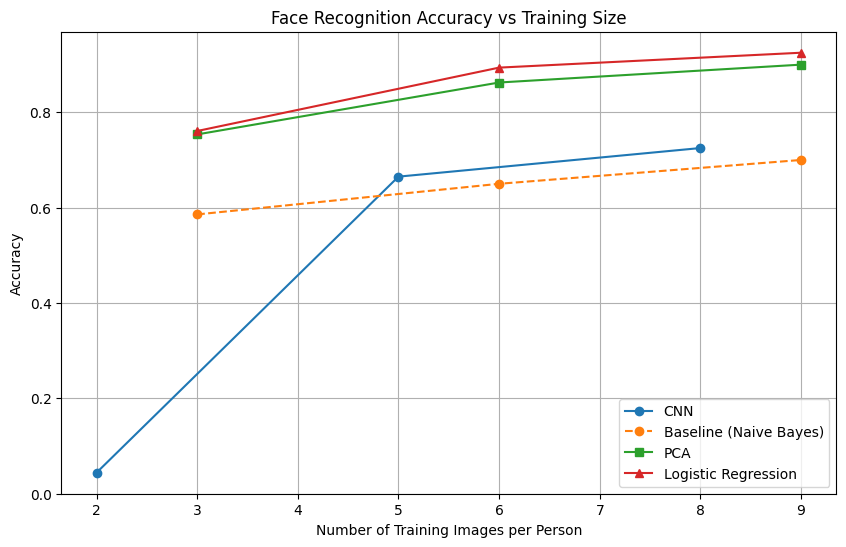

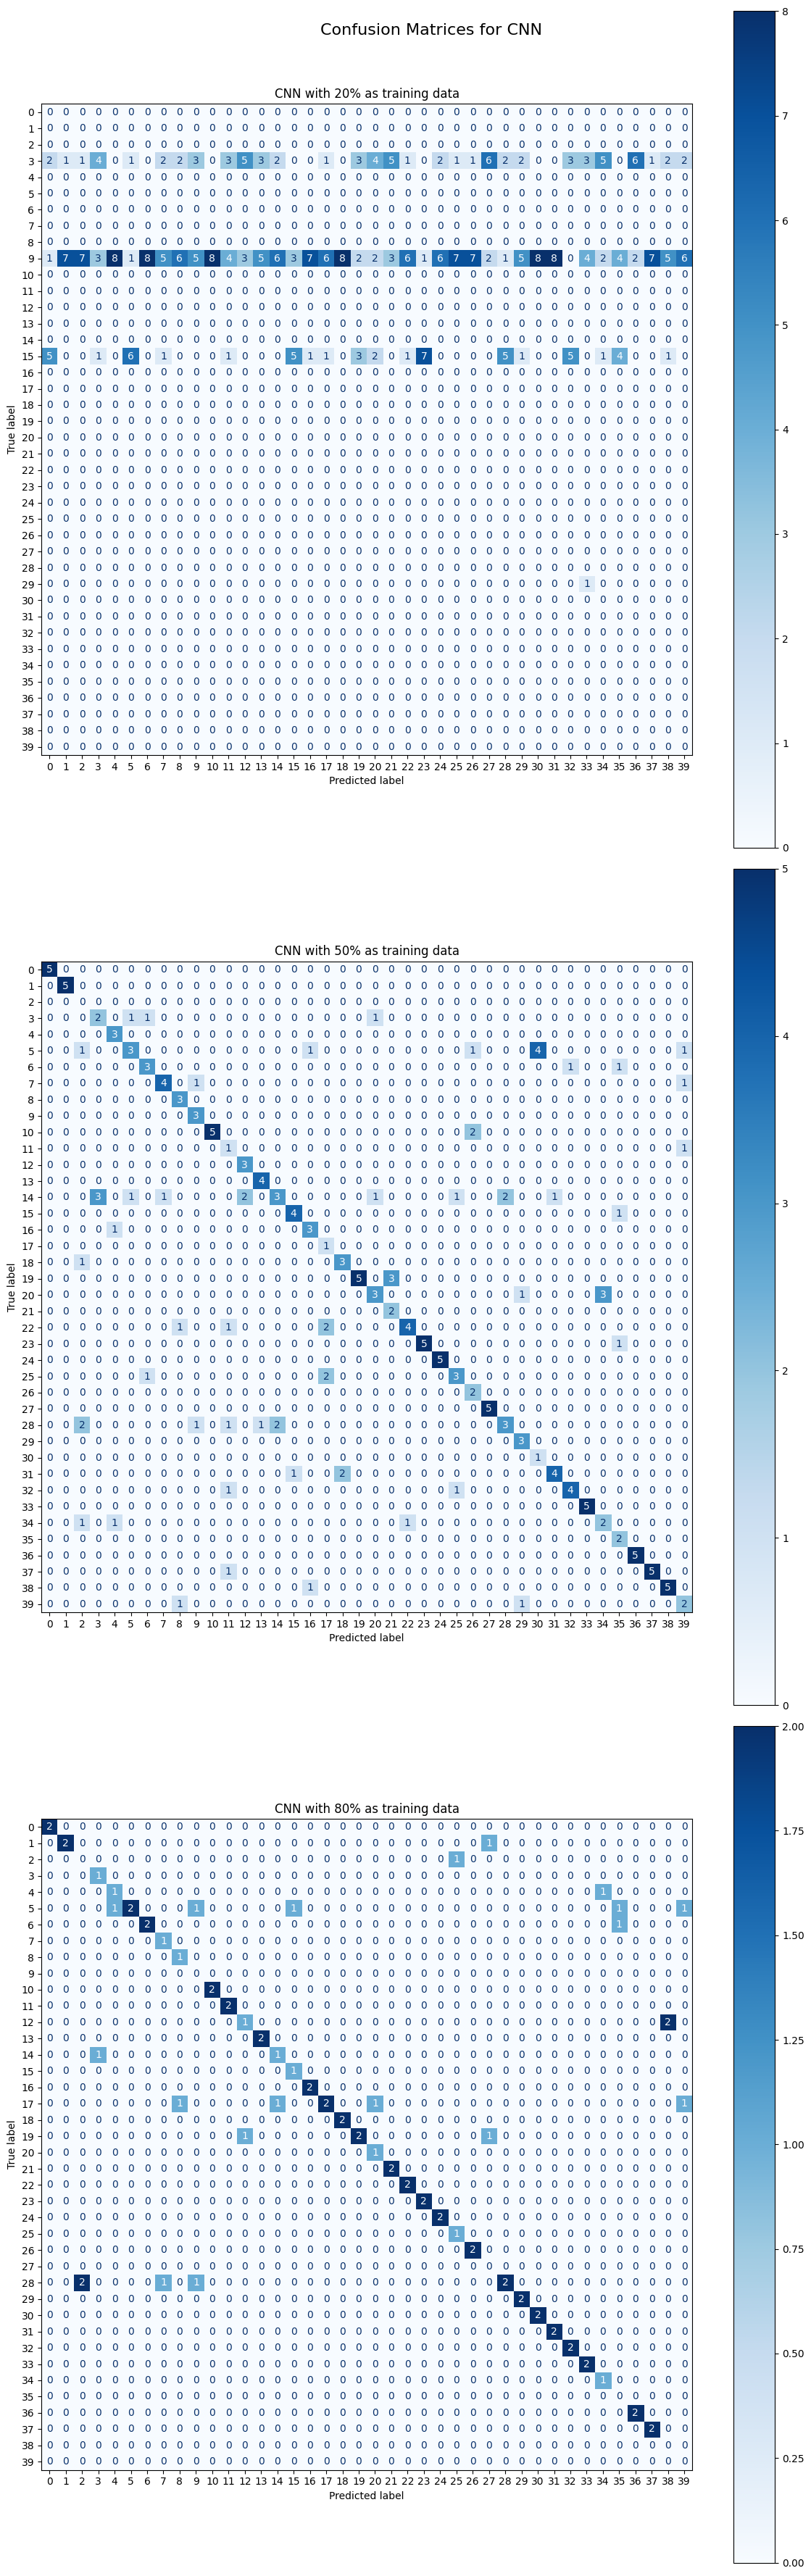

In [93]:

plt.figure(figsize=(10, 6))
# print(accuracy_score(cnn_results['CNN'],pred))
# print(cnn_results['CNN'])
plt.plot(cnn_results['train_k'], [accuracy_score(test,pred) for test,pred in cnn_results['CNN']], marker='o', label='CNN')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['Baseline']], marker='o', linestyle='--', label='Baseline (Naive Bayes)')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['PCA']], marker='s', label='PCA')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['Logistic Regression']], marker='^', label='Logistic Regression')

plt.title('Face Recognition Accuracy vs Training Size')
plt.xlabel('Number of Training Images per Person')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


fig, axes = plt.subplots(3, 1, figsize=(12, 36))
fig.suptitle(f"Confusion Matrices for CNN", fontsize=16)

for ax, (test, pred), size in zip(axes, cnn_results[label], cnn_results['train_k']):
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test, pred))
  disp.plot(cmap='Blues', ax=ax, colorbar=True)
  ax.set_title(f"{label} with {size*10}% as training data")

plt.tight_layout()
plt.show()


# IMDB Movie Review Dataset
Description from https://www.tensorflow.org/datasets/catalog/imdb_reviews:
> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

In [ ]:
import tensorflow_datasets
import numpy as np

Load dataset

In [ ]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Get subset of the data for training and testing (2000 samples each). Convert Keras dataset to lists of strings and labels.

In [ ]:
x_train = []
y_train = []

for sample, label in train_dataset.take(2000):
  x_train.append(sample.numpy())
  y_train.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset.take(2000):
  x_test.append(sample.numpy())
  y_test.append(label.numpy())

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])

# Add your baseline

Here is the code for my baseline, along with an explanation of how it works and why it makes sense for this problem.

#### Naive Bayes for Text
See lectures 18, 19

# Run the experiments

Here is the code I used to get the results below!

# Report your results

Check these amazing plots I have below!

# Extra Credit (10 points)

Explore data augmentation techniques for both tasks.
* (3 points) For the image task, you may use the built-in Keras data augmentation function (tf.keras.preprocessing.image.ImageDataGenerator).
* (5 points) For the text task, you may find an external function that you import or write your own data augmentation.
* (2 points) Describe what data augmentation methods you used and the motivation behind them (why you thought they would help).
